In [20]:
import numpy as np
import pyvibdmc.simulation_utilities as util
import pyvibdmc as dmc
from pyvibdmc import potential_manager as pm
import matplotlib.pyplot as plt
import sys,os
import pandas as pd

In [2]:
pot_dir = '/home/fenris/McCoy_Group/dvr/sample_potentials/FortPots/Partridge_Schwenke_H2O/'
py_file = 'h2o_potential.py'
pot_func = 'water_pot'

water_pot = pm.Potential(potential_function=pot_func,
                      python_file=py_file,
                      potential_directory=pot_dir,
                      num_cores=2)

In [3]:
eq_coord = np.array([[1.81005599,  0.        ,  0.        ],
                       [-0.45344658,  1.75233806,  0.        ],
                       [ 0.        ,  0.        ,  0.        ]])
cds = np.tile(eq_coord, (1001, 1, 1))
d_r = np.linspace(-1, 1, num=1001)
padded_d_r = np.zeros(cds.shape)
padded_d_r[:,0,0] = d_r
cds += padded_d_r

In [4]:
def V_mat(V, cds):
    return np.diag(V(cds))

def T_mat(x_grid):
    d_x = x_grid[1] - x_grid[0]
    dim = len(x_grid)
    c = 1/(2*d_x**2*MU)
    T_matrix = c*np.fromfunction(np.vectorize(T_generator), (dim, dim))
    return T_matrix

def T_generator(i,j):
    c = (-1)**(i-j)
    return c*np.pi**2/3 if i==j else c*2/(i-j)**2

def DVR(V, cds):
    a = np.min(cds[:,0,0])
    b = np.max(cds[:,0,0])
    x_grid= cds[:,0,0]
    V_matrix = V_mat(V, cds)
    T_matrix = T_mat(x_grid)
    E,evecs = np.linalg.eigh(V_matrix+T_matrix)
    
    return E, evecs, x_grid

In [5]:
MU = util.Constants.reduced_mass('O-H', to_AU=True)

def V_MO(x):
    return water_pot.getpot(x)

In [6]:
E_n, evecs, x_grid = DVR(V_MO, cds)

In [7]:
E_n = util.Constants.convert(E_n, 'wavenumbers', to_AU=False)
print(E_n[:10])

[ 1927.82803306  5655.43863442  9221.98977115 12631.9958488
 15911.79480013 19184.38375902 22681.41315625 26557.6740081
 30832.14539248 35476.99186395]


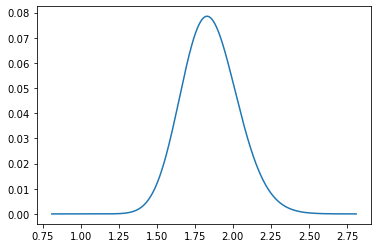

In [8]:
plt.plot(x_grid, evecs[:,0])

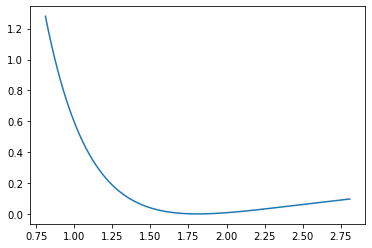

In [9]:
plt.plot(cds[:,0,0], water_pot.getpot(cds))

In [10]:
pot_dir = '/home/fenris/McCoy_Group/conv/h2o_dmc/'
py_file = 'h2o_nn_pot.py'
pot_func = 'h2o_pot'

water_pot_nn = pm.Potential(potential_function=pot_func,
                      python_file=py_file,
                      potential_directory=pot_dir,
                      num_cores=2)

In [11]:
def V_MO_nn(x):
    return water_pot_nn.getpot(x)

In [12]:
E_n_nn, evecs_nn, x_grid_nn = DVR(V_MO_nn, cds)

In [13]:
E_n_nn = util.Constants.convert(E_n_nn, 'wavenumbers', to_AU=False)
print(E_n_nn[:10])

[ 1928.10413392  5655.79947712  9223.27439277 12637.32412765
 15904.24114073 19149.66319522 22629.0230366  26499.70173877
 30774.21014525 35421.12993948]


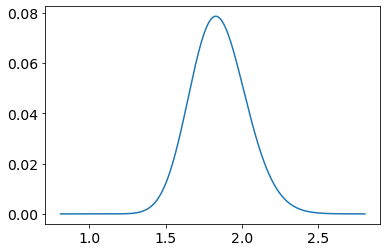

In [14]:
plt.plot(x_grid_nn, evecs_nn[:,0])

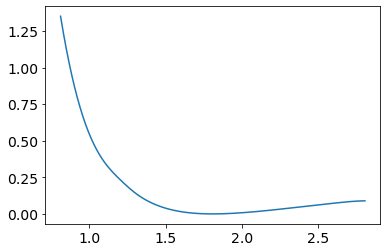

In [15]:
plt.plot(cds[:,0,0], water_pot_nn.getpot(cds))

In [29]:
E = pd.DataFrame({'nth Excited State':np.arange(10), '$E_{PS}$':E_n[:10], '$E_{NN}$':E_n_nn[:10]})
E

,nth Excited State,$E_{PS}$,$E_{NN}$
0,0,1927.828033,1928.104134
1,1,5655.438634,5655.799477
2,2,9221.989771,9223.274393
3,3,12631.995849,12637.324128
4,4,15911.794800,15904.241141
5,5,19184.383759,19149.663195
6,6,22681.413156,22629.023037
7,7,26557.674008,26499.701739
8,8,30832.145392,30774.210145
9,9,35476.991864,35421.129939


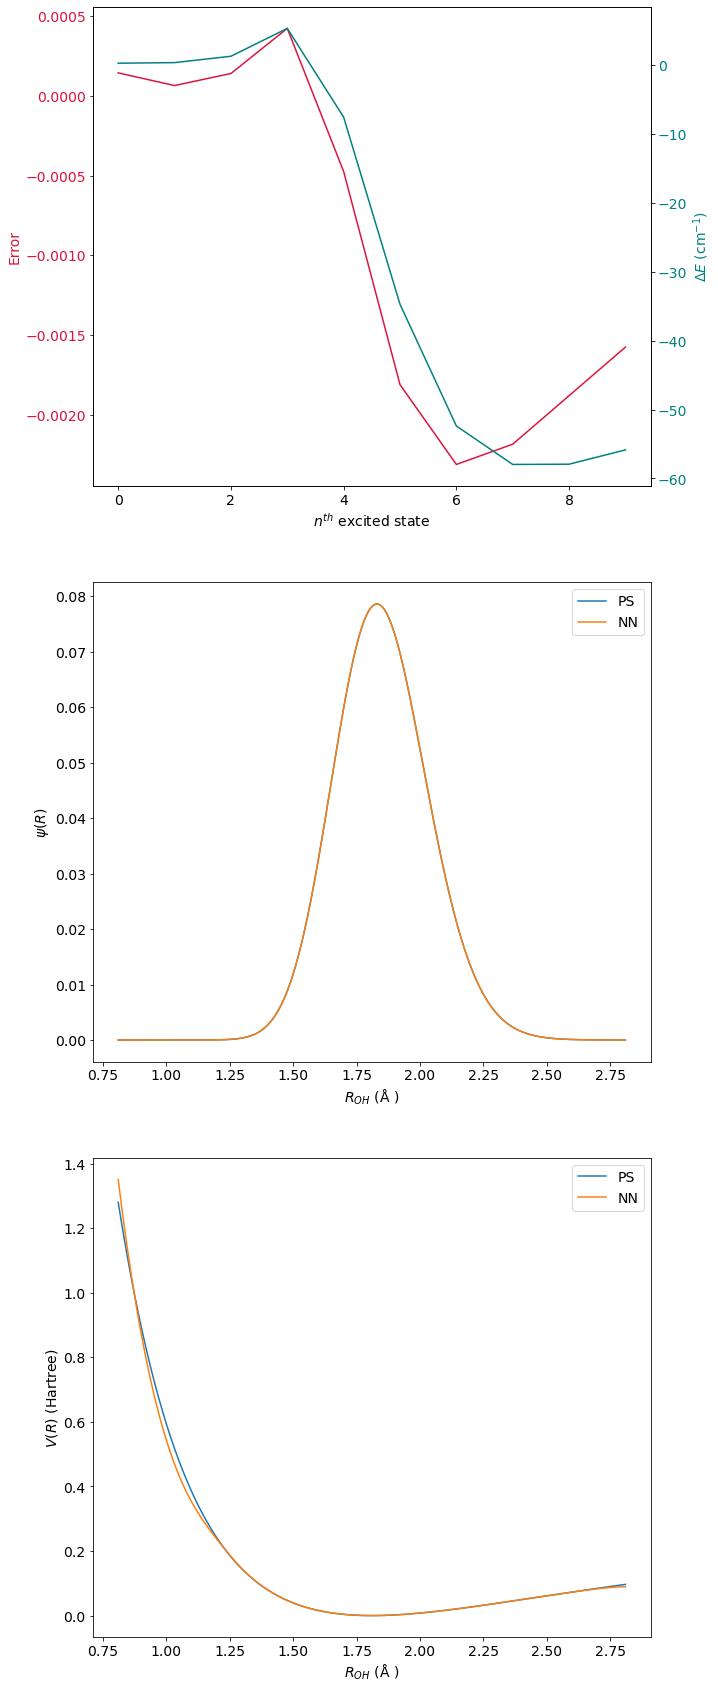

In [67]:
fig = plt.figure(figsize=(10,30))

energy = fig.add_subplot(3,1,1)
energy.plot(np.arange(10), (E_n_nn[:10] - E_n[:10])/E_n[:10], color='crimson')
energy.set_xlabel('$n^{th}$ excited state')
energy.set_ylabel('Error', color='crimson')
energy.tick_params(axis='y', labelcolor='crimson')
ax_2 = energy.twinx()
ax_2.plot(np.arange(10), E_n_nn[:10] - E_n[:10], color='teal')
ax_2.set_ylabel('$\Delta E$ (cm$^{-1}$)', color='teal')
ax_2.tick_params(axis='y', labelcolor='teal')

wf = fig.add_subplot(3,1,2)
wf.plot(x_grid, evecs[:,0], label='PS')
wf.plot(x_grid, evecs_nn[:,0], label='NN')
wf.set_xlabel('$R_{OH}$ ($\mathrm{\AA}$ )')
wf.set_ylabel('$\psi(R)$')
wf.legend()

pe = fig.add_subplot(3,1,3)
pe.plot(x_grid, water_pot.getpot(cds), label='PS')
pe.plot(x_grid, water_pot_nn.getpot(cds), label='NN')
pe.set_xlabel('$R_{OH}$ ($\mathrm{\AA}$ )')
pe.set_ylabel('$V(R)$ (Hartree)')
pe.legend()

plt.show()